# Autoencoders in PyTorch
In this notebook, we'll build an autoencoder with PyTorch.
Just as a reminder, autoencoders attempt to find a compressed representation for some dataset. The model does this by encoding the data into a smaller number of values, a compressed vector. During training, the vector is passed through a decoder which attempts to reconstruct the original data. The loss is then the mean squared error between the reconstruction and the original data.

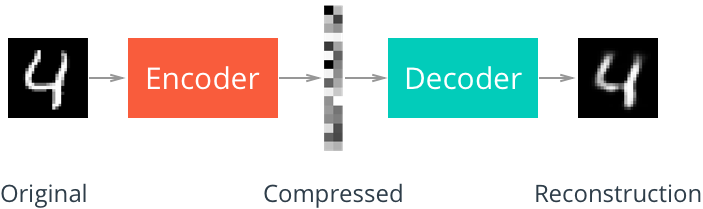

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.autograd import Variable 

In [ ]:
# Get the data 
transform = transforms.Compose([transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Building the network
Here we'll build the network for the autoencoder.

Again, we start it by creating a class inheriting from nn.Module. The way I did this was splitting the forward pass into two methods, encoder and decoder. This is because after training, we will usually just want the encoded vector. In the forward method, we just connect the two.

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Define the layers and operations here

    def forward(self, x):

        x = self.encoder(x)
        logits = self.decoder(x)

        return logits

    def encoder(self, x):
        # Forward pass through the encoder
        return x

    def decoder(self, x):
        # Forward pass through the decoder
        return x

## The Encoder
For the encoder, we'll use convolutional layers with nn.Conv2d. You can use max-pooling for downsampling, with nn.MaxPool2d, but I chose to leave it out since many people seem to be moving away from pooling and downsampling with strides instead. I also added dropout with the nn.Dropout2d module. With the dropout module, you'll want to turn off dropout while you're infering, you can do that with net.eval(). To turn dropout back on, use net.train(). This also works for things like batch normalization.

So, in the encoder forward pass, it would look something like

x = self.drop(F.relu(self.conv1(x)))
with the convolutional layer, a ReLU activation, and dropout.

Typically you'll start with the first convolutional layer as the deepest layer, then use shallower layers as you compress the representation. For instance, you could use three max-pool-convolution layers with depths 16, 8, and 8. If you downsample by two with each layer (use strides of two and "same" padding), you'll end up with a layer that is 8x4x4. Feel free to choose whatever depths you want, and however many layers you as well.

## The decoder
With the decoder, you'll need to upsample the layers. This can be done with transposed convolutions (nn.ConvTranspose2d) or by nearest neighbor upsampling (nn.UpsamplingNearest2d). With transposed convolutions, you define the kernel size and strides like normal, but when you call the module, you can set an output size. That is, you'd define the operation as

self.upconv = nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1)
then in the forward pass

x = self.upconv(x, output_size=(14,14))
Similarly with nearest neighbor, you set the size of the output self.upsample = nn.UpsamplingNearest2d(size=(14, 14)).

If you're using transposed convolutions, the forward pass would look like x = self.drop(F.relu(self.upconv1(x, output_size=(7,7)))) to upsample to 7x7 layer, with a ReLU activation and dropout. Typically you'd upsample through a few layers, something like depths of 8, 8, and 16. Then the output layer would be another convolutional layer with a depth of 1 to match the MNIST images. If you were working with color images like CIFAR or SVHN, you'd use a depth of 3.

Which upsampling method you choose depends on a lot of factors. Distill recently published a good article about the differences. They show that transposed convolutional layers can sometimes result in checkerboard artifacts and nearest neighbor upsampling works better. But, I've found that transposed convolutions work great for this model. So, try out both methods if you're curious.

If you need a refresher on building autoencoders with convolutions and upsampling, check out this notebook. And here we used transposed convolutions to build the generator of a GAN.

In [ ]:
class Network(nn.Module):
    def __init__(self, drop_prob=0.5):
        super().__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 16, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(16, 8, 3, stride=1, padding=1)
        
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1)
        self.upconv2 = nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1)
        self.upconv3 = nn.ConvTranspose2d(16, 32, 3, stride=1, padding=1)
        self.upconv4 = nn.ConvTranspose2d(32, 64, 3, stride=2, padding=1)
        self.out = nn.ConvTranspose2d(64, 1, 3, stride=1, padding=1)
        
        self.drop = nn.Dropout2d(p=drop_prob)
    
    def forward(self, x):
        x = self.encode(x)
        logits = self.decode(x)
        
        return logits

    def encode(self, x):
        x = self.drop(F.relu(self.conv1(x)))
        x = self.drop(F.relu(self.conv2(x)))
        x = self.drop(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        return x
        
    def decode(self, x):
        x = self.drop(F.relu(self.upconv1(x, output_size=(7,7))))
        x = self.drop(F.relu(self.upconv2(x, output_size=(14,14))))
        x = self.drop(F.relu(self.upconv3(x, output_size=(14,14))))
        x = self.drop(F.relu(self.upconv4(x, output_size=(28,28))))
        x = self.out(x)
        return x

Test to make sure it works for one training pass, shouldn't get any errors here.

In [ ]:
def test_network(net, trainloader):

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    dataiter = iter(trainloader)
    images, labels =  next(dataiter)

    # Create Variables for the inputs and targets
    inputs = Variable(images)
    targets = Variable(images)

    # Clear the gradients from all Variables
    optimizer.zero_grad()

    # Forward pass, then backward pass, then update weights
    output = net.forward(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()

    return True

In [ ]:
net = Network()
test_network(net, trainloader)

In [ ]:
def view_recon(img, recon):
    ''' Function for displaying an image (as a PyTorch Tensor) and its 
        reconstruction also a PyTorch Tensor 
    '''
    
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
    axes[0].imshow(img.numpy().squeeze())
    axes[1].imshow(recon.data.numpy().squeeze())
    for ax in axes:
        ax.axis('off')
        ax.set_adjustable('box')

## Training the network
Now we'll train the network. We're using the mean square error for the loss, so we'll use criterion = nn.MSELoss(). As before, we update the weights by doing a forward pass through the network, then calculate the loss, get the gradients with loss.backward(), then make an update step with optimizer.step() (with an Adam optimizer, optim.Adam).

In [ ]:
net = Network(drop_prob=0.0)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epochs = 10
print_every = 200  # Number of training steps to print losses
show_every = 1000  # Number of training steps to show reconstructions
cuda = False        # Train on GPU or not

if cuda:
    net.cuda()

steps = 0
running_loss = 0
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        steps += 1

        inputs = Variable(images)
        targets = Variable(images)
        
        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        optimizer.zero_grad()
        
        output = net.forward(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            net.eval()
            stop = time.time()
            # Test accuracy
            val_loss = 0
            for ii, (images, labels) in enumerate(testloader):
                
                #images = images.resize_(images.size()[0], 784)
                inputs = Variable(images, volatile=True)
                targets = Variable(images, volatile=True)
                if cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()
                
                output = net.forward(inputs)
                val_loss += criterion(output, targets).item()
                
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test loss: {:.4f}..".format(val_loss/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )
            
            running_loss = 0
            start = time.time()
            net.train()
              
        if steps % show_every == 0:
            net.cpu()
            net.eval()
            img = images[3]
            x = Variable(img.resize_(1, *img.size()), volatile=True)
            recon = net(x)
            
            view_recon(img, recon)
            plt.show()
            if cuda:
                net.cuda()
            net.train()

## Encoding images
Now that the network is trained, let's encode an image and check out the vector representation.

In [ ]:
net.cpu()
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
img = images[3]
# Need to resize the single image to add a fourth dimension
x = Variable(img.resize_(1, *img.size()), volatile=True)
comp = net.encode(x)

In [ ]:
comp_arr = comp.data.numpy().squeeze()
comp_arr = comp_arr.reshape((8, 16))
plt.imshow(comp_arr, cmap='Reds')
